# Developing market models using frequentist linear regression

In [1]:
# Install Yahoo finance package


# Import relevant Python packages
import statsmodels.api as sm
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
#plt.style.use('seaborn')
from datetime import datetime




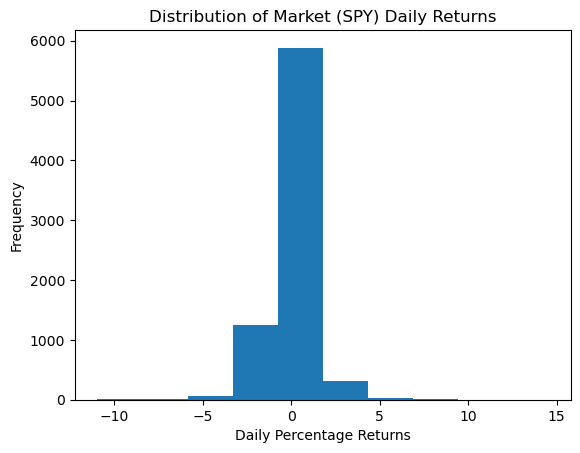

Descriptive Statistics of the Market's daily percentage returns:
count    7554.000000
mean        0.043484
std         1.192537
min       -10.942354
25%        -0.448806
50%         0.066905
75%         0.595489
max        14.519745
Name: market, dtype: float64


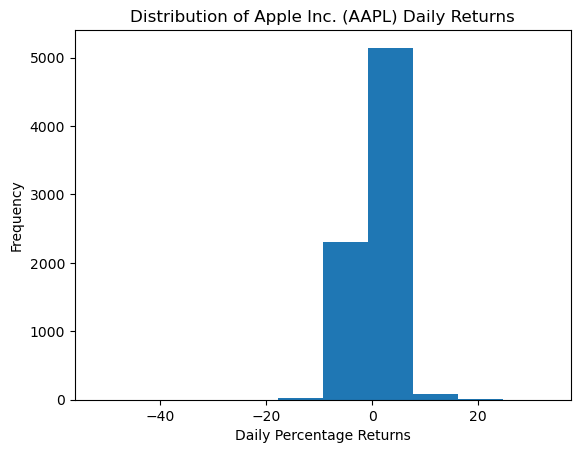

Descriptive Statistics of the Apple's daily percentage returns:
count    7554.000000
mean        0.116955
std         2.741895
min       -51.869212
25%        -1.185806
50%         0.050978
75%         1.391341
max        33.228040
Name: stock, dtype: float64


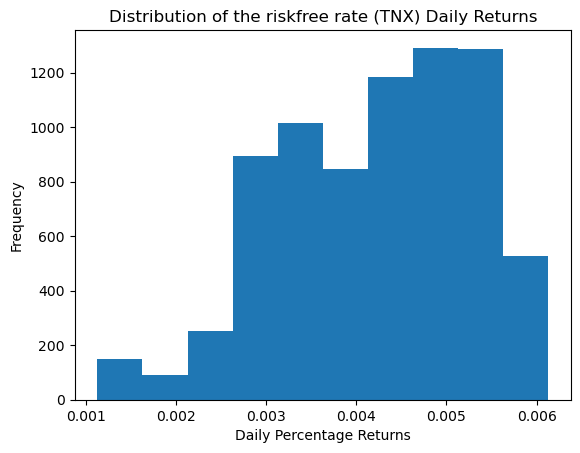

Descriptive Statistics of the 10 year note daily percentage returns:
count    7534.000000
mean        0.004217
std         0.001073
min         0.001125
25%         0.003378
50%         0.004390
75%         0.005092
max         0.006129
Name: riskfree, dtype: float64


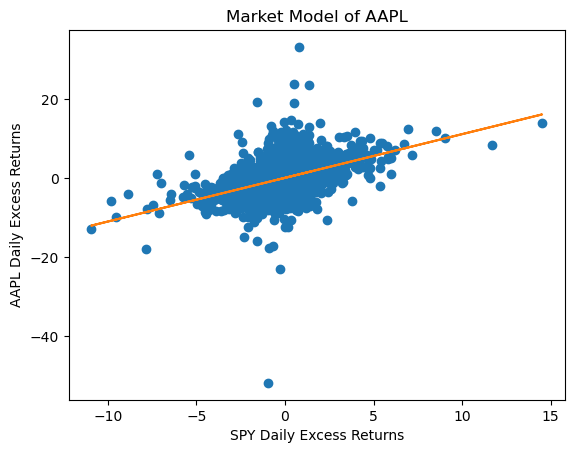

According to AAPL's Market Model, the security had a realized Alpha of 0.07% and Beta of 1.11


In [4]:
# Import financial data
start = datetime(1993, 3, 1)
end = datetime(2023, 3, 1)

daily_returns = pd.DataFrame()

# S&P 500 index is a proxy for the market
market = yf.Ticker('SPY').history(start=start, end=end)
# Ticker symbol for Apple, the most liquid stock in the world
stock = yf.Ticker('AAPL').history(start=start, end=end)
# 10 year US treasury note is the proxy for risk free rate
riskfree_rate = pd.DataFrame(yf.Ticker('^TNX').history(start=start, end=end))
# Create dataframe to hold daily returns of securities
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100

riskfree_rate.index = riskfree_rate.index.tz_localize(None)
daily_returns.index = daily_returns.index.tz_localize(None)

# Compounded daily rate based on 360 days for the calendar year used in the bond market
riskfree_values = (1 + riskfree_rate['Close']) ** (1/360) - 1


daily_returns['riskfree'] = (1 + riskfree_rate['Close']) ** (1/360) - 1


# Plot and summarize the distribution of daily returns
plt.hist(daily_returns['market']), plt.title('Distribution of Market (SPY) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
# Analyze descriptive statistics
print("Descriptive Statistics of the Market's daily percentage returns:\n{}".format(daily_returns['market'].describe()))

plt.hist(daily_returns['stock']), plt.title('Distribution of Apple Inc. (AAPL) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
# Analyze descriptive statistics
print("Descriptive Statistics of the Apple's daily percentage returns:\n{}".format(daily_returns['stock'].describe()))

plt.hist(daily_returns['riskfree']), plt.title('Distribution of the riskfree rate (TNX) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
# Analyze descriptive statistics
print("Descriptive Statistics of the 10 year note daily percentage returns:\n{}".format(daily_returns['riskfree'].describe()))
# Examine missing rows in the dataframe
market.index.difference(riskfree_rate.index)
# Fill rows with previous day's risk-free rate since daily rates are generally stable
daily_returns = daily_returns.ffill()
# Drop NaNs in first row because of percentage calculations
daily_returns = daily_returns.dropna()
# Check dataframe for null values
daily_returns.isnull().sum()
# Check first five rows of dataframe
daily_returns.head()
# AAPL's Market Model based on daily excess returns

# Daily excess returns of AAPL
y = daily_returns['stock'] - daily_returns['riskfree']
# Daily excess returns of the market
x = daily_returns['market'] - daily_returns['riskfree']

# Plot the data
plt.scatter(x,y)

# Add the constant vector to obtain the intecept
x = sm.add_constant(x)

# Use Ordinary Least Squares algorithm to find the line of best fit
market_model = sm.OLS(y, x).fit()

# Plot the line of best fit
plt.plot(x, x*market_model.params[0]+market_model.params['const'])
plt.title('Market Model of AAPL'), plt.xlabel('SPY Daily Excess Returns'), plt.ylabel('AAPL Daily Excess Returns'), plt.show();

# Display the values of alpha and beta of AAPL's market model
print("According to AAPL's Market Model, the security had a realized Alpha of {0}% and Beta of {1}".format(round(market_model.params['const'],2), round(market_model.params[0],2)))



In [5]:
print(market_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2276.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:33:23   Log-Likelihood:                -17342.
No. Observations:                7554   AIC:                         3.469e+04
Df Residuals:                    7552   BIC:                         3.470e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0693      0.028      2.504      0.0